# CP640 - Machine Learning
## Assignment 2 - Email Spam Classification

### Learning Objectives
After completing this assignment, you should be comfortable:

- Feature engineering
- Using sklearn to build simple and more complex linear models
- Identifying informative variables through EDA
- Classification using logistic regression
- Classification metrics

### Marking Breakdown

Question | Points
--- | ---
Question 1a | 1
Question 1b | 1
Question 1c | 1
Question 2a | 1
Question 2b | 1
Question 2c | 1
Question 2d | 1
Question 2e | 1
Question 2f | 1
Question 2g | 1
Question 2h | 1
Question 2i | 1
Question 2j | 1
Question 3a | 1
Question 3b | 1
Total | 15

One of the following marks below will be added to the **Total** above.

### Code Quality

| Rank | Points | Description |
| :-- | :-- | :-- |
| Youngling | 1 | Code is unorganized, variables names are not descriptive, redundant, memory-intensive, computationally-intensive, uncommented, error-prone, difficult to understand. |
| Padawan | 2 | Code is organized, variables names are descriptive, satisfactory utilization of memory and computational resources, satisfactory commenting, readable. |
| Jedi | 3 | Code is organized, easy to understand, efficient, clean, a pleasure to read. #cleancode |

### Load a Dataset From the Google Drive to Google Colab
First you need to mount your google drive to colab

In [70]:
# from google.colab import drive
# drive.mount('/content/drive')

### Import Your Python File
Once you’ve mounted your Google Drive, you can import your Python file in Colab.

In [71]:
import sys
# sys.path.append('/content/drive/MyDrive/Fall_2023/assignment2')
sys.path.append('./assignment2')

## Setup Notebook

In [72]:
# Import 3rd party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import local libraries
from threshold_prediction_plot import threshold_prediction_plot, sigmoid

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# Overview

Have you ever wondered how Google intercepts all of those spam emails so they don't end up in your inbox? In this assignment, you will build a model to classify emails as `spam` or `not-spam`.

# The Data
The data can be found in the file `emails.csv` in the root director. The `csv` contains the following columns.

Columns of `emails.csv` include:
- `id`: An identifier for the training example
- `subject`: The subject of the email
- `email`:  The text of the email
- `label`: 1 if the email is `spam`, 0 if the email is `not-spam`

The file `emails.csv` contains 7513 rows where each row is an email.

First, let's import `emails.csv` to a DataFrame.

In [73]:
# email_data = pd.read_csv('/content/drive/MyDrive/Fall_2023/assignment2/emails.csv', index_col=0)
email_data = pd.read_csv('./emails.csv', index_col=0)
email_data.head()

,id,subject,email,label
4282,4282,Subject: RE: [ILUG] Dell GX260 V Redhat 7.3\r\n,> When I get a box I don't want any of that in...,0
6293,6293,Subject: IBM eNews: Aktuelle Informationen von...,IBM eNews\r\n 4. Juli 2002\r\n \r\n Liebe Lese...,0
2349,2349,"Subject: [zzzzteana] Height, weight, girth, et...","http://www.guardian.co.uk/uk_news/story/0,3604...",0
3786,3786,Subject: Re: The GOv gets tough on Net Users.....,Hire a really talented skywriter to doodle nud...,0
4731,4731,Subject: Lander risks missing Mars trip\r\n,"URL: http://www.newsisfree.com/click/-4,805285...",0


# Data Cleaning and Pre-processing
First, let's convert the email and subject text to lower case. This is based on the assumption that what differentiates `spam` emails from `not-spam` emails is case-insensitive.

In [74]:
email_data['subject'] = email_data['subject'].str.lower()
email_data['email'] = email_data['email'].str.lower()

Next, let's check if our data contains any missing values.

In [75]:
print('Missingness before imputation:')
print(email_data.isnull().sum())

Missingness before imputation:
id         0
subject    6
email      0
label      0
dtype: int64


We can see there are 6 missing values for `'subject'`. This means that a subject was not included in the email and therefore, we can we replace missing values with appropriate filler values (i.e., NaN values in the subject or email columns will be replaced with empty strings `''`). Note that while there are no missing values in the `'label'` column, we should be careful when replacing missing value labels. Doing so without consideration may introduce significant bias into our model when fitting.

In [76]:
email_data[['subject', 'email']] = email_data[['subject', 'email']].fillna('')
print('Missingness after imputation:')
print(email_data.isnull().sum())

Missingness after imputation:
id         0
subject    0
email      0
label      0
dtype: int64


Lastly, let's split `email_data` into training and validation datasets. We'll need this validation data to assess the performance of our classifier once we are finished training. Note that we have set the seed (random_state) to `0`. This will produce a pseudo-random sequence of random numbers that is the same for everyone. Do not modify this in the following questions.

You'll notice that we've added an argument for `'stratify'` and set it equal to our training target `'label'`. This is done to maintain the proportion of each class in `train` and `val`. If 20% of the emails are `spam` in the dataset, then we want 20% of the emails in the `train` and `val` datasets to be also be `spam`.

In [77]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(email_data, test_size=0.1, random_state=0, stratify=email_data['label'])
print('Train:', train.shape, 'Test:', val.shape)
print('Train spam proportion: {:.2f} %'.format(train['label'][train['label'] == 1].shape[0] / train.shape[0] * 100))
print('Test spam proportion: {:.2f} %'.format(val['label'][val['label'] == 1].shape[0] / val.shape[0] * 100))

Train: (6761, 4) Test: (752, 4)
Train spam proportion: 25.63 %
Test spam proportion: 25.66 %


# 1. Feature Engineering
We would like to take the text of an email and predict whether the email is `spam` or `not-spam`. This is a classification problem and we will be using logistic regression to train a classifier. Recall that to train a logistic regression model, we need an `nD` numeric feature array `X` and a `1D` array of corresponding binary labels `y`. Unfortunately, our data are text, not numbers. Therefore, we will need to extract some numeric features from the raw email text. Each row of `X` is an email and each column of `X` contains one feature for all the emails.

## Question 1a
In the cell below, we have printed the text of the `'email'` column for a `not-spam` and a `spam` email in the training set.

In [78]:
index = 1  # You can change this to see other examples
not_spam = train.loc[train['label'] == 0, 'email'].iloc[index]
print(not_spam)

url: http://diveintomark.org/archives/2002/10/05.html#perl_programmers_are_so_cute
 date: 2002-10-05t21:33:22-05:00
 
 _ian hickson_: #include web-log.txt[1]. &#8220;i used some of perl's niftier 
 features, such as using method lookup instead of a switch statement for the 
 preprocessing instruction dispatching, and exceptions instead of passing error 
 codes back and forth.&#8221; he he. perl programmers are so cute when they 
 imitate python programmers.
 
 
 
 [1] http://ln.hixie.ch/?start=1033841933&count=1
 
 



In [79]:
spam = train.loc[train['label'] == 1, 'email'].iloc[index]
print(spam)

this is a multi-part message in mime format.
 
 ------=_nextpart_000_c16f3_01c260c3.2978b160
 content-type: text/plain;
 	charset="windows-1252"
 content-transfer-encoding: quoted-printable
 
  an additional income stream
  from your current book of business!
   =09
  	  	 	 =09
  	 agent commission:
 $92,000=20
  client:
  87-year-old male
  82-year-old female
 
  result:
  $2,300,000 second to die
  policy, minimal cash value.  policy was no longer
  required. insured utilized a
  life settlement and received
  $300,000. agent commission:
 $30,000=20
  client:
  70-year-old male with health complications
 
  result:
  $1,000,000 policy with small
  cash value. insured utilized
  a life settlement and
  received $300,000. agent commission:
 $90,000=20
 
  client:
  89-year-old female
 
  result:
  $2,000,000 policy with an
  annual premium of $110,000.
  policy expires at age 95.
  insured utilized a life
  settlement and received
  $325,000.=20
  	  	 	 =09
 =20
 
 multiple opportuni

Discuss one thing you notice that is different between `spam` emails and `not-spam` emails that might help with the identification of `spam`.

*Type your answer here, replacing this text.*

## Question 1b
Create a function called `word_detector` that takes in a list of words and a pandas Series of email texts. It should output a DataFrame containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does.

The following code
```python
word_detector(['hello', 'bye', 'world'],
              pd.Series(['hello', 'hello worldhello']))
```
should output the following DataFrame.
<br>
<!-- ![alt text](https://drive.google.com/uc?id=1BFEL_6TIbl_SE4NvFYuPq1yUqrZ8vt_B) -->
![image info](./images/q1b.png)

<br>

In [80]:
def word_detector(words, texts):

    """
    Returns a DataFrame with detections of words.

    Parameters:
        words (list): A list of words to look for.
        texts (Series): A series of strings to search in.

    Returns:
        (DataFrame): A DataFrame with len(words) columns and texts.shape[0] rows.
    """

    # Write your code here
    rows = np.zeros((len(texts), len(words)))
    for i,text in enumerate(texts) :
        for j,word in enumerate(words):
            if word in text:
                rows[i,j] = 1
    # print(rows)
    return pd.DataFrame(rows, columns=words)

Let's check it out.

In [81]:
word_detector(['hello', 'bye', 'world'],
              pd.Series(['hello', 'hello worldhello']))

,hello,bye,world
0,1.0,0.0,0.0
1,1.0,0.0,1.0


And, we can check if it works for our `'email'` column in `train`.

In [82]:
word_detector(['hello', 'bye', 'world'], train['email']).head()

,hello,bye,world
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


Is is important that the index values output from `word_detector()` match with the indices in `train`. Let's check quickly.

In [83]:
train.head()

,id,subject,email,label
6277,6277,subject: [spambayes] maybe change x-spam-dispo...,"\r\n >> accordingly, i wrote unheader.py, ...",0
2342,2342,subject: perl programmers are so cute\r\n,url: http://diveintomark.org/archives/2002/10/...,0
3147,3147,subject: sun\r\n,"well, it looks like sun are going ahead with\r...",0
643,643,subject: [spambayes] spambayes package?\r\n,\r\n >> before we get too far down this ro...,0
7128,7128,subject: re: use of base image / delta image f...,> ben mord said:\r\n > \r\n > >ah. in that cas...,0


## Question 1c
We need to identify some features that allow us to distinguish `spam` emails from `not-spam` emails. One idea is to compare the distribution of a single feature in `spam` emails to the distribution of the same feature in `not-spam` emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of `spam` emails with the word to the proportion of `not-spam` emails with the word.

The following plot (which was created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words.
```python
words = ['body', 'business', 'html', 'money', 'offer', 'please']
```
![image info](./images/q1c.png)

Create a bar chart like the one above comparing the proportion of `spam` and `not-spam` emails containing certain words. Choose a set of **six** words that are different from the ones above, but also have different proportions for the two classes. We'll help you get started.

First let's create a list of the words we're interested in.

In [84]:
words = ['body', 'business', 'html', 'money', 'offer', 'please']

Next, let's use our function `word_detector()` to detect the words in `words`.

In [85]:
df_q1c = pd.concat((word_detector(words, train['email']),
                    train[['label']]), axis=1)
df_q1c.head()

,body,business,html,money,offer,please,label
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0


use the `.melt()` method to "unpivot" the DataFrame `df_q1c`.

In [86]:
df_q1c = df_q1c.melt('label')
df_q1c.head(10)

,label,variable,value
0,0.0,body,0.0
1,0.0,body,0.0
2,1.0,body,0.0
3,0.0,body,0.0
4,0.0,body,0.0
5,0.0,body,0.0
6,NaN,body,0.0
7,1.0,body,0.0
8,0.0,body,0.0
9,0.0,body,0.0


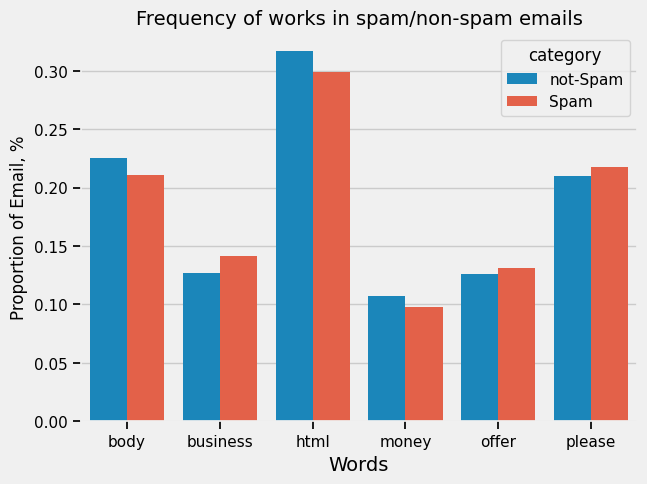

In [87]:
# Write your code here
df_q1c['category'] = df_q1c['label'].map({0: 'not-Spam', 1: 'Spam'})
ax = sns.barplot(x='variable', y='value', hue='category', data=df_q1c, ci=None) 
plt.xlabel('Words', fontsize=14)
plt.ylabel('Proportion of Email, %', fontsize=12)
plt.title('Frequency of works in spam/non-spam emails', fontsize=14)
plt.show()

You can text your code with these words as a quick sanity check.
```python
words = ['body', 'business', 'html', 'money', 'offer', 'please']
```

# 2. Model Building
Our new function `word_detector(['hello', 'bye', 'world'], train['email'])` outputs a numeric DataFrame containing features for each email. This means we can use it as input to train a classifier.

## Question 2a
Let's consider 5 words that might be useful as features to distinguish `spam` from `not-spam` emails.
```python
words = ['drug', 'bank', 'prescription', 'memo', 'private']
```
Use `words` as well as the `train` DataFrame to create two DataFrames: `X_train` and `y_train`.

`X_train` should be a DataFrame of 0s and 1s created by using `word_detector()` on all the emails in `train`.

`y_train` should be a 1D DataFrane of the correct labels for each email in `train`.

In [88]:
words = ['drug', 'bank', 'prescription', 'memo', 'private']

# Write your code here
X_train = word_detector(words, train['email'])
y_train = train['label']

Check `X_train`

In [89]:
X_train.head()

,drug,bank,prescription,memo,private
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


and check y_train.

In [90]:
y_train.head()

6277    0
2342    0
3147    0
643     0
7128    0
Name: label, dtype: int64

## Question 2b
Now that we have `X_train` and `y_train`, we can build a model with `scikit-learn`. Using the `LogisticRegression()` classifier, train a logistic regression model using `X_train` and `y_train`. Then, output the model's training accuracy below. You should get an accuracy of around `0.75`.

You must also create a function `accuracy()` that takes two 1D numpy arrays (`y_true` and `y_pred`) and outputs an accuracy score. `y_true` and `y_pred` arrays can only contain **0**'s `not-spam` or **1**'s `spam`.

Do **NOT** use the `sklearn` function `accuracy_score()` from `sklearn.metrics` to compute the accuracy.

Hint: ```np.equal(y_true, y_pred)```

In [91]:
def accuracy(y_true, y_pred):

    """
    Returns a accuracy score for two 1D numpy array of the same length.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (float): Accuracy score of y_true and y_pred.
    """

    # Write your code here
    
    return np.equal(y_true, y_pred).astype(int).sum()/ len(y_true)


In [92]:
from sklearn.linear_model import LogisticRegression

# Write your code here
model = LogisticRegression(fit_intercept=False)
model.fit(X_train, y_train)

X_val = word_detector(words, val['email'])
y_true = val['label']
training_accuracy = accuracy(y_true, model.predict(X_val))

# Print training accuracy
print('Training Accuracy: {:.3f}'.format(training_accuracy))

Training Accuracy: 0.746


Whoa! 75% accuracy isn't bad considering we're only using a few simple features. But wait, isn't this dataset imbalanced?

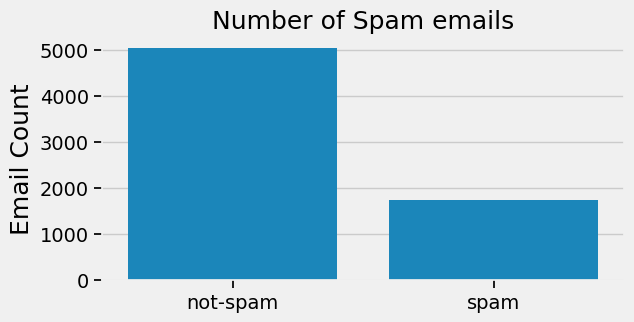

In [93]:
df_temp = train['label'].map(lambda val: 'spam' if
                             val == 1 else 'not-spam').to_frame()

plt.figure(figsize=(6, 3))
plt.title('Number of Spam emails', fontsize=18)
ax = sns.countplot(x='label', data=df_temp)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Email Count', fontsize=18)
plt.show()

Yes, this dataset is clearly imbalanced. To be specific, ~25% of the data are `spam` and ~75% are `not-spam`. But wait, our accuracy was ~75% too? Something seems off here.

## Question 2c
Let's create another classifier called `zero_predictor()` that takes our features `X_train` as input and always predicts `0` (never predicts positive `1`). `zero_predictor()` should output a 1D numpy array with length equal to the number of rows in `X_train`.

In [94]:
def zero_predictor(X_train):

    """
    Returns a 1D numpy array with a length equal to the number of
    rows in X_train.

    Parameters:
        X_train (DataFrame): DataFrame of training features.

    Returns:
        (1D numpy array): Zero predictions for every entry in X_train.
    """

    # Write your code here
    return np.zeros(X_train.shape[0])

Next, use your function `accuracy()` to compute the accuracy of your model `zero_predictor()`.

In [95]:
# Write your code here
zero_predictor_accuracy = accuracy(y_true, zero_predictor(word_detector(words, val['email'])))

# Print zero predictor accuracy
print('Zero Predictor Accuracy: {:.3f}'.format(zero_predictor_accuracy))

Zero Predictor Accuracy: 0.743


Wow, we achieved almost the same accuracy as our fancy `LogisticRegression` model by simply predicting zeros.

The take-away lesson here is that you shouldn’t use accuracy on imbalanced problems. This is because it is easy to get a high accuracy score by simply classifying all observations as the majority class (`not-spam` in our case).

Because our problem is imbalanced, we'll need to find some other metric to help us evaluate our model.

## Evaluating Classifiers
We just learned that our classifier isn't as good as the accuracy suggests. Firstly, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure. Accuracy on the training set doesn't always translate to accuracy in the real world (on the test set). But, you'll remember we split out dataset into `train` and `val` and we'll evaluate our model on `val` later on. But, the main issue is that our dataset is imbalanced which accuracy is not well suited to.

When thinking about which metric to use to evaluate our model, its essential to consider the use case. Our classifier will be used for filtering email. Our model will prevent messages labeled `spam` from reaching someone's inbox.

There are two kinds of errors the model can make:

**False Positive (FP):** a `not-spam` (negative,0) email gets flagged as `spam` (positive,1) and filtered out of the inbox. A `FP` is commonly refered to as `Type I Error`.

**False Negative (FN):** a `spam` (positive,1) email gets mislabeled as `not-spam` (negative,0) and ends up in the inbox. A `FN` is commonly refered to as `Type II Error`.

And there are two correct predictions the model can make:

**True Positive (TP):** a `spam` (positive,1) email that is classified as `spam` (positive,1).

**True Negative (TN):** a `not-spam` (negative,0) email that is classified as `not-spam` (negative,0).

These definitions depend both on the true labels and the predicted labels.

## Question 2d
Let's revisit our `zero_predictor()` from the previous question. For this question, we need to compute how many `false positives`, `false negatives`, `true positives` and `true negatives` this classifier generates when evaluated on the training set and its results are compared to `y_train`. Do NOT use any sklearn functions.

First, you need to create four functions:
- `count_false_positives()`
- `count_false_negatives()`
- `count_true_positives()`
- `count_true_negatives()`

Hint: Check out the numpy function `np.logical_and()`

In [96]:
y_pred = zero_predictor(word_detector(words, val['email']))
np.logical_and(y_true==1, y_pred==0).astype(int).sum()

np.int64(193)

In [97]:
def count_false_positives(y_true, y_pred):

    """
    Returns the number of false positives.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (int): The number of false positives detected.
    """

    # Write your code here
    return np.logical_and(y_pred == 1, y_true == 0).astype(int).sum()

def count_false_negatives(y_true, y_pred):

    """
    Returns the number of false negatives.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (int): The number of false negatives detected.
    """

    # Write your code here
    return np.logical_and(y_pred == 0, y_true == 1).astype(int).sum()



def count_true_positives(y_true, y_pred):

    """
    Returns the number of true positives.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (int): The number of true positives detected.
    """

    # Write your code here
    return np.logical_and(y_pred == 1, y_true == 1).astype(int).sum()

def count_true_negatives(y_true, y_pred):

    """
    Returns the number of false negatives.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (int): The number of true negatives detected.
    """

    # Write your code here
    return np.logical_and(y_pred == 0, y_true == 0).astype(int).sum()   

In [98]:
# Count predictions
zero_predictor_fp = count_false_positives(y_true, zero_predictor(X_val))
zero_predictor_fn = count_false_negatives(y_true, zero_predictor(X_val))
zero_predictor_tp = count_true_positives(y_true, zero_predictor(X_val))
zero_predictor_tn = count_true_negatives(y_true, zero_predictor(X_val))

# Print results
print('There are {} records in train.'.format(train.shape[0]))
print('There are {} false positives.'.format(zero_predictor_fp))
print('There are {} false negatives.'.format(zero_predictor_fn))
print('There are {} true positives.'.format(zero_predictor_tp))
print('There are {} true negatives.'.format(zero_predictor_tn))
print('fp + fn + tp + tn = {}'.format(sum([zero_predictor_fp,
                                           zero_predictor_fn,
                                           zero_predictor_tp,
                                           zero_predictor_tn])))

There are 6761 records in train.
There are 0 false positives.
There are 193 false negatives.
There are 0 true positives.
There are 559 true negatives.
fp + fn + tp + tn = 752


A quick check is to ensure that `fp + fn + tp + tn = train.shape[0]`.

You'll see that there are no `false positives` or `true positives`, which makes sense because our simple model `zero_predictor()` predicts `0` for every record. There are no positive predictions, so there can be no `false positives` or `true positives`.

`false positives` and `false negatives` may be of differing importance depending on the use case, leading us to consider more ways of evaluating a classifier. Beyond accuracy, `precision` and `recall` are common metrics for evaluating classifiers.

### Precision
**Precision** measures the proportion of emails flagged as `spam` that are actually `spam`. In other field, such as medicine, `Precision` is refered to as `Positive Predictive Value (PPV)`.

**precision = $\frac{\text{TP}}{\text{TP} + \text{FP}}$**

### Recall
**Recall** measures the proportion of `spam` emails that were correctly flagged as `spam`. In other field, such as medicine, `Recall` is refered to as `Sensitivity`.

**recall = $\frac{\text{TP}}{\text{TP} + \text{FN}}$**

### False-Alarm Rate
**False-alarm rate (far)** measures the proportion (**$\frac{\text{FP}}{\text{FP} + \text{TN}}$**) of `non-spam` emails that were incorrectly flagged as `spam`.

**far = $\frac{\text{FP}}{\text{FP} + \text{TN}}$**

The two graphic below may help you understand precision and recall visually.
<br>
![image info](./images/precision_recall.png)
<!-- ![alt text](https://drive.google.com/uc?id=10MXJK-mUkXsi39x7VMERyg3ak3mi-qYD) -->
<br>

## Question 2e
For this question, we need to compute the `accuracy`, `precision`, `recall` and `false-alarm rate` for our simple `zero_predictor()` model when evaluated on the training set and its results are compared to `y_train`. Do NOT use any sklearn functions.

We already have a function for `accuracy`. For this question, you'll need to create three functions:
- `precision()`
- `recall()`
- `false_positive_rate()`

Hint: Use your functions from the last question.
- `count_false_positives()`
- `count_false_negatives()`
- `count_true_positives()`
- `count_true_negatives()`

In [99]:
def precision(y_true, y_pred):

    """
    Returns the precision score.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (float): The precision.
    """

    # Write your code here
    return count_true_positives(y_true, y_pred) / (count_true_positives(y_true, y_pred) + count_false_positives(y_true, y_pred))

def recall(y_true, y_pred):

    """
    Returns the recall score.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (float): The recall.
    """

    # Write your code here
    return count_true_positives(y_true, y_pred) / (count_true_positives(y_true, y_pred) + count_false_negatives(y_true, y_pred))

def false_alarm_rate(y_true, y_pred):

    """
    Returns the false alarm rate.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (float): The false positive rate.
    """

    # Write your code here
    return count_false_positives(y_true, y_pred) / (count_false_positives(y_true, y_pred) + count_true_negatives(y_true, y_pred))

In [100]:
# Count metrics
zero_predictor_accuracy = accuracy(y_true, zero_predictor(X_val))
zero_predictor_precision = precision(y_true, zero_predictor(X_val))
zero_predictor_recall = recall(y_true, zero_predictor(X_val))
zero_predictor_far = false_alarm_rate(y_true, zero_predictor(X_val))

# Print results
print('Accuracy {:.3f}'.format(zero_predictor_accuracy))
print('Precision: {:.3f}'.format(zero_predictor_precision))
print('Recall: {:.3f}'.format(zero_predictor_recall))
print('False Alarm Rate: {:.3f}'.format(zero_predictor_far))

Accuracy 0.743
Precision: nan
Recall: 0.000
False Alarm Rate: 0.000


## Question 2f
Comment on the results from Question 2e. For each of `accuracy`, `precision`, `recall`, and `false-alarm rate`, briefly explain why we see the result that we do.

## Answer 2f
The zero_preditctor is an extreme case of predictor which always returns negtive. Therefore, True Positive(TP) and False Positive(FP) will always be zero accordingly. 
### Accuracy
Accracy = TP+TN/(TP+FP+TN+FN), since the dataset is highly imbalanced, i.e. non-spam data comprised about 75% of the data, this is what accuracy reflects. 
### Precision
Precision = TP/(TP+FP), which measures the proportion of emails flagged as `spam` that are actually `spam` since TP + FP =0, it results a divided by zero error. 

### Recall
Recall = TP/(TP+FN), which measures the proportion of `spam` emails that were correctly flagged as `spam`, results zero since TP is zero. As it is called 'Sentitiviey', zero_predictor sense nothing at all for.

### False-alarm rate
False-alrm rate = FP/(FP+TN), which measures the proportion of `non-spam` emails that were incorrectly flagged as `spam` the results zero as well since FP is always, i.e. it will never trigger any alarm. 

## Question 2g
Using the function you have created, compute the `accuracy`, `precision`, `recall`, and `false-alarm rate` of the `LogisticRegression` classifier created and trained in Question 2b.

In [101]:
# Write your code here
lr_predictor_accuracy = accuracy(y_true, model.predict(X_val))
lr_predictor_precision = precision(y_true, model.predict(X_val))
lr_predictor_recall = recall(y_true, model.predict(X_val))
lr_predictor_far = false_alarm_rate(y_true, model.predict(X_val))

# Print results
print('Accuracy {:.3f}'.format(lr_predictor_accuracy))
print('Precision: {:.3f}'.format(lr_predictor_precision))
print('Recall: {:.3f}'.format(lr_predictor_recall))
print('False Alarm Rate: {:.3f}'.format(lr_predictor_far))

Accuracy 0.746
Precision: 0.521
Recall: 0.130
False Alarm Rate: 0.041


## Question 2h
Are there more false positives or false negatives when using the `logistic regression` classifier from Question 2b?

## Answer 2h
False Positive(FP) is less than False Negtive(FN) based on the fact that Accuracy is Precision than Recall. This is because according to the equation, the only difference between Accuracy and Precision is how much FP and FN contributes to the divident, i.e. the bigger the Accuracy the less FP and visa versa. 

Precsission~=0.5 means that half of the alarm it triggered is correct while Recallf~0.13 means this model is not sentitive engouth to the spam. The reason behind will be discussed in detail in answer 2i

## Question 2i

Given the words we gave you above `['drug', 'bank', 'prescription', 'memo', 'private']`, give one reason why our `Logistic Regression` classifier is performing so poorly.

Hint: Think about how prevalent these words are in the email set. Maybe the bar chart from Question 1c could be helpful?

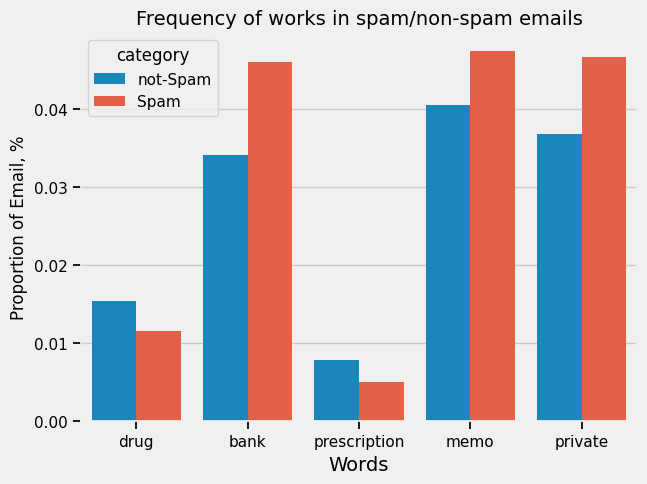

In [102]:
# Write your code here (if you want)
words = ['drug', 'bank', 'prescription', 'memo', 'private']
df_q2i = pd.concat((word_detector(words, train['email']),
                    train[['label']]), axis=1)
df_q2i.head()

df_q2i = df_q2i.melt('label')
df_q2i.head(10)

df_q2i['category'] = df_q2i['label'].map({0: 'not-Spam', 1: 'Spam'})
ax = sns.barplot(x='variable', y='value', hue='category', data=df_q2i, ci=None) 
plt.xlabel('Words', fontsize=14)
plt.ylabel('Proportion of Email, %', fontsize=12)
plt.title('Frequency of works in spam/non-spam emails', fontsize=14)
plt.show()

## Answer 2i
One noticible reaons that the classifier based on words`['drug', 'bank', 'prescription', 'memo', 'private']` is performing so badly is because these words only appear in less than 0.3% of the emails. That's makes it very insensitive to the spam email. This explains why its **Recall** score is as low as 0.13. 

## Question 2j
Which of these two classifiers would you prefer for a `spam` filter and why? Describe your reasoning and relate it to at least one of the evaluation metrics `accuracy`, `precision`, `recall`, and `false-alarm rate` we have computed so far.

## Answer 2j
Judging from the evaluation metrics, `model2` outperformes `model` significantly. It has better `accuracy`(0.831>0.746), `precision`(0.729>0.521), much better `recall(`(0.542>>0.130), with little higher `false-alarm rate`(0.069~=0.041). So it is very obvious that `model2` is a better choice. 

One noticible reaons why there're huge different in `recall(` is that the words`['body', 'business', 'html', 'money', 'offer', 'please']` in `model2` is much more prevalent in the overall dataset, 2.2% compared to the words`['drug', 'bank', 'prescription', 'memo', 'private']` only appear in less than 0.3% of the emails. This has been explained in detail in **Answer 2i**. 

Another interesting finding is that even for `accuracy`, `model2` still works more effectively than `model`. Countray to  `model2`'s words, which doe't have visible difference in frequency of between spam/not-spam, words like `bank, memo, private` have more footprint in spam email than non-spam ones. To understand this will be very complicated. To better understand the principle behind, we need tools to throughly analyze the words that "best" identify spam emails and the relationship between such "best classifiying words". The former coulld possibily be achieved via TF-IDF while the letter requires embedding layer to compare the difference. After that, we may have some statistics to explain why certain set of words perfrom better than others in **precision**. However, a dedicated study is beyond the scope of this discussion, we can come back to it if we have chance later. 

## Build another Model
We'll be comparing models in the next section, so let's create another one using the words from Question 1c `['body', 'business', 'html', 'money', 'offer', 'please']`.

In [103]:
# Define words
words2 = ['body', 'business', 'html', 'money', 'offer', 'please']

# Get train data
X_train2 = word_detector(words2, train['email'])
y_train2 = train[['label']]

# Train model
model2 = LogisticRegression()
model2.fit(X_train2, y_train2)
y_true2 = y_train2.values.flatten()

# Print metrics
print('Accuracy {:.3f}'.format(accuracy(y_true2, model2.predict(X_train2))))
print('Precision: {:.3f}'.format(precision(y_true2, model2.predict(X_train2))))
print('Recall: {:.3f}'.format(recall(y_true2, model2.predict(X_train2))))
print('False Alarm Rate: {:.3f}'.format(false_alarm_rate(y_true2, model2.predict(X_train2))))

Accuracy 0.831
Precision: 0.729
Recall: 0.542
False Alarm Rate: 0.069


# 3. More Evaluation Metrics
Ok, so we have `precision` and `recall`, which appear to be more useful for evaluating our model than `accuracy` when we have imbalanced data. In some applications, we may only care about `precision` or `recall`, however, what if we care about both? In this case, the `F-beta` metric is useful. `F-beta` is the harmonic mean of `precision` and `recall` and is expressed by the following equation.

**$F_{\beta} = (1 + \beta^{2}) \frac{precision * recall}{\beta^{2} * precision + recall}$**

When choosing beta in your `F-beta` score, the more you care about `recall` over `precision` the higher `beta` should be. For example, with the `F1` score, we care equally about `recall` and `precision`, however, with the `F2` score, `recall` is twice as important and `precision`.

More generally, with 0 < `beta` < 1, we care more about `precision`and with `beta` > 1, we care more about `recall`.

`F1` is the common form of `F-beta` and is widely used in many machine learning applications.

**$F_{1} = 2 \frac{precision * recall}{precision + recall}$**

## Question 3a
Create a function `f_beta` that computes the `F-beta` score we defined above. You may want to use some of the functions you have already created.

In [104]:
def f_beta(y_true, y_pred, beta):

    """
    Returns the F-beta score.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels
                                 np.array([1, 0, 0, 1, ..]).
        beta (float): The beta parameter for the F-beta metric.

    Returns:
        (float): The F-beta score.
    """

    # Write your code here
    return (1+beta**2) * precision(y_true, y_pred) * recall(y_true, y_pred) / (beta**2 * precision(y_true, y_pred) + recall(y_true, y_pred))

In [105]:
# Print results
print("Model 1\nwords = {}\nF1 Score: {:.3f}\n".format(words, f_beta(y_train, model.predict(X_train), beta=1)))
print("Model 2\nwords = {}\nF1 Score: {:.3f}".format(words2, f_beta(y_true2, model2.predict(X_train2), beta=1)))

Model 1
words = ['drug', 'bank', 'prescription', 'memo', 'private']
F1 Score: 0.264

Model 2
words = ['body', 'business', 'html', 'money', 'offer', 'please']
F1 Score: 0.622


Wow, thats a pretty significant difference in `F1` score between these two lists of words. Keep this in mind for `Project 1` where your task will be to improve the model.

### Probability Thresholds
You'll notice that when computing our metrics, we used the `model.predict()` method. For our model, it predicts a `0` (`not-spam`) or `1` (`spam`) for a given array of features. Let's check out the `model.predict()` method.

In [106]:
model.predict(X_train)

array([0, 0, 1, ..., 0, 0, 0])

But, in the lesson 3, we learned that the output of the logistic model is a sigmoid function, which looks something like this.

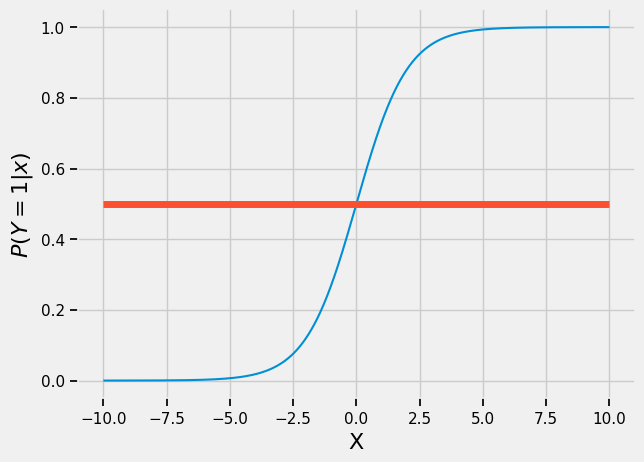

In [107]:
x_sigmoid = np.arange(-10, 10, 0.001)
y_sigmoid = sigmoid(x_sigmoid)
plt.plot(x_sigmoid, y_sigmoid, '-')
plt.plot([-10, 10], [0.5, 0.5], lw=5)
plt.xlabel('X', fontsize=16)
plt.ylabel(r'$P(Y = 1 | x)$', fontsize=16);

When you use the `.predict()` method, `scikit-learn` automatically applied a threshold of `0.5`. So in the plot above, everything less than **X = 0** is classified as **y = 0** and everything greater than **X = 0** is classified as **y = 1**. However, the threshold is something we can tune to our specific use case.

Take a minute and mess around with the interactive visualization below to gain an understanding for how the choice of your threshold can impact our metrics `accuracy`, `precision`, and `recall`. I have created a dummy dataset with one feature `the number of word counts for "body"` and a logistic model that predicts the probability of an email being `spam` given the `"body"` count.

In [108]:
threshold_prediction_plot()

interactive(children=(IntSlider(value=50, description='threshold'), Output()), _dom_classes=('widget-interact'…

Depending on what is important to us, we can set the threhold. For example, if we want a model with high precision, a threshold of `0.8` would be work.

In [109]:
threshold_prediction_plot(0.8)

interactive(children=(IntSlider(value=80, description='threshold'), Output()), _dom_classes=('widget-interact'…

However, if recall is important, a threshold of `0.1` might work better.

In [110]:
threshold_prediction_plot(0.1)

interactive(children=(IntSlider(value=10, description='threshold'), Output()), _dom_classes=('widget-interact'…

So, how do we access these probabilities? We can use the `model.predict_proba()` method.

In [111]:
model.predict_proba(X_train)

array([[0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.35599538, 0.64400462],
       ...,
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ]])

`model.predict_proba()` returns the probability of the sample for each class in the model, where classes are ordered as they are in `model.classes_`.

In [112]:
model.classes_

array([0, 1])

So, the first column of `model.predict_proba(X_train)` is the probability of **0** `not-spam` and the second column is the probability of **1** `spam`. You notice that because there are only two classes, the sum of the first and second columns equals 1.

In [113]:
model.predict_proba(X_train)[0, 0] + model.predict_proba(X_train)[0, 1]

np.float64(1.0)

### Precision-Recall Curve
A useful visualization for understanding the trade-off between `precision` and `recall` is the `Precision-Recall (PR) Curve`. The `PR Curve` is a curve that combines `precision` and `recall` in a single visualization. For every threshold, you calculate `precision` and `recall` and plot it. The closer to the upper-right corner, the better your more is.

You can use this plot to make an educated decision when it comes to the `precision-recall` trade-off, where the higher the `recall` the lower the `precision`. Knowing at which `recall` your `precision` starts to fall fast can help you choose an optimal `threshold` and deliver a better model.

Spend some time playing with the interactive visualization below which displays the `PR Curve` for model 1 and model 2.

In [114]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.metrics import precision_recall_curve

# Initialize
init_notebook_mode(connected=True)
fig = go.Figure()

# Model 1
y_scores = model.predict_proba(X_train)[:, 1]
model_precisions, model_recalls, model_thresholds = precision_recall_curve(y_train, y_scores)
model_thresholds = np.append(model_thresholds, [1.])
df1 = pd.DataFrame({'precision': model_precisions, 'recall': model_recalls, 'threshold': model_thresholds})
trace1 = go.Scatter(x=df1['recall'], y=df1['precision'], name='Model 1', mode='lines', hovertext=df1['threshold'],
                    hovertemplate='Precision=%{y}<br>Recall=%{x}<br>Threshold=%{hovertext}')

# Model 2
y_scores2 = model2.predict_proba(X_train2)[:, 1]
model_precisions2, model_recalls2, model_thresholds2 = precision_recall_curve(y_true2, y_scores2)
model_thresholds2 = np.append(model_thresholds2, [1.])
df2 = pd.DataFrame({'precision': model_precisions2, 'recall': model_recalls2, 'threshold': model_thresholds2})
trace2 = go.Scatter(x=df2['recall'], y=df2['precision'], name='Model 2', mode='lines', hovertext=df2['threshold'],
                    hovertemplate='Precision=%{y}<br>Recall=%{x}<br>Threshold=%{hovertext}')

layout = go.Layout(title='Precision-Recall Curve',
                   xaxis=dict(title='Recall'),
                   yaxis=dict(title='Precision'))

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.layout.update(hovermode='closest')

iplot(fig)

## Question 3b
Below is a function that computes the `F1` score given a threshold. When we calculated the `F1` score in Question 3a, we used a default threshold value of `0.5`.

In [115]:
def f1_threshold(y_true, y_pred_proba, threshold):

    """
    Returns the F-beta score.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels
                                 np.array([0, 1, 0, 0, ..]).
        y_pred_proba (1D numpy array): 1D array of prediction probabilities
                                       for the positive class
                                       (model.predict_proba(X)[:, 1])
                                       np.array([0.12, 0.56, 0.23, 0.89, ..]).
        threshold (float): The probability threshold, which is a number
                           between 0 and 1.

    Returns:
        (float): The F1 score given a threshold.
    """

    # Calculate the binary predictions
    y_pred = (y_pred_proba >= threshold).astype(int)

    return f_beta(y_true, y_pred, beta=1)

In [116]:
def plot_f1_threshold(X, y, model):

    """
    Returns the F-beta score.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels
                                 np.array([0, 1, 0, 0, ..]).
        y_pred_proba (1D numpy array): 1D array of prediction probabilities
                                       for the positive class
                                       (model.predict_proba(X)[:, 1])
                                       np.array([0.12, 0.56, 0.23, 0.89, ..]).
        threshold (float): The probability threshold, which is a number
                           between 0 and 1.
    """

    # Create threshold array
    thresholds = np.arange(0, 1, 0.01)

    # Compute F1 scores for each threshold
    f1_scores = np.array([f1_threshold(y.values.flatten(), model.predict_proba(X)[:, 1], threshold)
                          for threshold in np.arange(0, 1, 0.01)])

    # Get finite values
    thresholds = thresholds[np.isfinite(f1_scores)]
    f1_scores = f1_scores[np.isfinite(f1_scores)]

    # Optimal values
    idx = np.argmax(f1_scores)
    f1_score = f1_scores[idx]
    threshold = thresholds[idx]

    # Plot
    fig = plt.figure(figsize=(12, 4))
    fig.subplots_adjust(wspace=0.2, hspace=0)
    ax1 = plt.subplot2grid((1, 2), (0, 0))
    ax2 = plt.subplot2grid((1, 2), (0, 1))
    ax1.set_title('Optimal F1 score is {:.2f} for a threshold of {:.2f}.'.format(f1_score, threshold), fontsize=12)
    ax1.plot(thresholds, f1_scores, '.-')
    ax1.plot([threshold, threshold], [0, 1], '-', label='Optimal F1')
    ax1.legend()
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('F1 Score')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])

    # Get PR curve
    prc_precisions, prc_recalls, prc_thresholds = precision_recall_curve(y.values.flatten(), model.predict_proba(X)[:, 1])
    precision_opt = precision(y.values.flatten(), (model.predict_proba(X)[:, 1] >= threshold).astype(int))
    recall_opt = recall(y.values.flatten(), (model.predict_proba(X)[:, 1] >= threshold).astype(int))

    # Plot
    ax2.set_title('Optimal Precision is {:.2f} and recall is {:.2f}.'.format(precision_opt, recall_opt), fontsize=12)
    ax2.plot(prc_recalls, prc_precisions)
    ax2.plot(recall_opt, precision_opt, 'o', label='Optimal PR')
    ax2.legend()
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])


Above is a function called `plot_f1_threshold()`, which generates a plot of the `F1` score as a function of the threshold value and the `precision-recall` curve. Below, is an example if the function being used for model 1 with `X_train` and `y_train` .

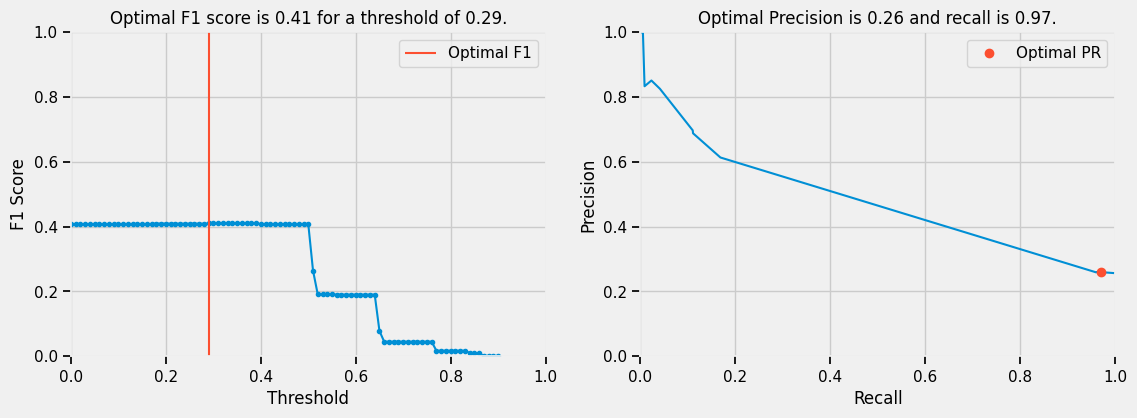

In [117]:
plot_f1_threshold(X_train, y_train, model)

For this question, you're task is to find the optimal `threshold`, `F1`, `precision` and `recall` for `model2`. You'll remember that `model2` uses features for these words `['body', 'business', 'html', 'money', 'offer', 'please']` (see variable `words2`).

First, which datset should you use to pick the optimal threshold (`train` or `val`), please explain your decision.

*Type your answer here, replacing this text.*

Next, use `plot_f1_threshold()` to find the optimal `threshold`, `F1`, `precision` and `recall` for `model2`.

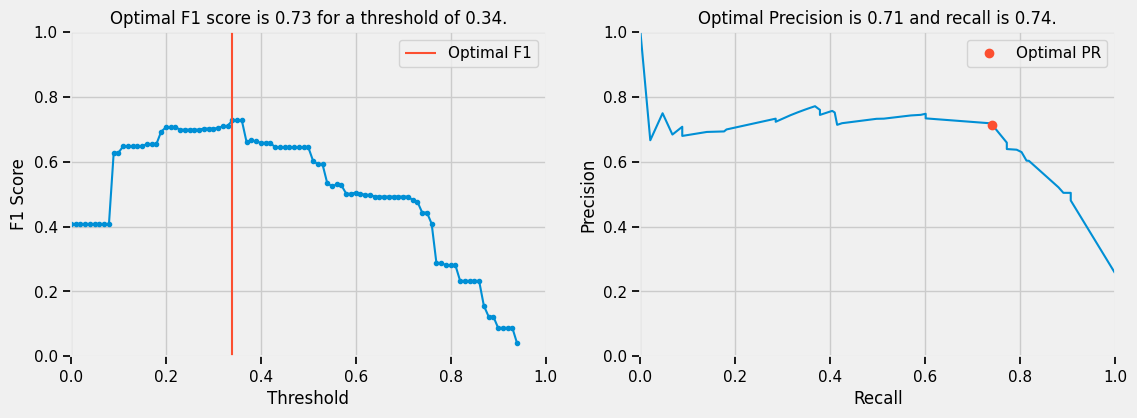

In [118]:
# Write your code here
y_val = val['label']
X_val = word_detector(words2, val['email'])
plot_f1_threshold(X_val, y_val, model2)

Next, let's print `F1`, `precision` and `recall` scores using the default `0.5` `threshold`.

In [119]:
print("Precision Score: {:.3f}".format(precision(y_val.values.flatten(), model2.predict(X_val))))
print("Recall Score: {:.3f}".format(recall(y_val.values.flatten(), model2.predict(X_val))))
print("F1 Score: {:.3f}".format(f_beta(y_val.values.flatten(), model2.predict(X_val), beta=1)))

Precision Score: 0.743
Recall Score: 0.570
F1 Score: 0.645


Lastly, reflect on the difference between the optimal values and those using the default `threshold` of `0.5`. Would you use the default on your next project?

**Congratulation, you're done Assignment 2. Review your answers and clean up your code before submitting on Dropbox. `#cleancode`**